## A simple MADE  implementation
This implementation does not sample masks during the training process, so the final loss is around 100, which is more or less similar to the result in the paper. 

In [1]:
import numpy as np
import tensorflow as tf
keras = tf.contrib.keras

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import utils

# Checking autoregressive properties of MADE masks

In [3]:
masks = utils.create_autoregressive_masks(10, [10, 10])

X = tf.placeholder(tf.float32, shape=[1, 10])
h = X
for k, mask in enumerate(masks):
    h = tf.matmul(h, tf.to_float(mask))

X_hat = h
X, X_hat

(<tf.Tensor 'Placeholder:0' shape=(1, 10) dtype=float32>,
 <tf.Tensor 'MatMul_2:0' shape=(1, 10) dtype=float32>)

## This should have zero on last element

In [4]:
with tf.Session() as sess:    
    dX = tf.gradients(X_hat[0, -1], X)[0]
    gradiends = sess.run(dX, {X: np.ones([1, 10])})
gradiends

array([[43., 33., 33., 26., 20., 14., 14.,  5.,  1.,  0.]], dtype=float32)

## This should have all zeros

In [5]:
with tf.Session() as sess:    
    dX = tf.gradients(X_hat[0, 0], X)[0]
    gradiends = sess.run(dX, {X: np.ones([1, 10])})
gradiends

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# Build a simple MADE model and its autoregressive properties
We are going to train MADE on MNIST dataset with single hidden unit. However this implementation can be easily extended to have more layers

In [6]:
sess = tf.InteractiveSession()

In [7]:
hidden_size = 500 
input_size = 784
batch_size = 100

# define masks
masks = utils.create_autoregressive_masks(input_size, [hidden_size])
# define simple model
x_ph = tf.placeholder(tf.float32, [batch_size, input_size])
hidden = utils.masked_dense(x_ph, hidden_size, mask=masks[0])
x_hat = utils.masked_dense(hidden, input_size, mask=masks[1], activation=None)
# loss
ce_loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=x_ph, 
    logits=x_hat) / batch_size

loss = tf.reduce_sum(ce_loss)

### Doing brute-force test for checking whether model satisfies autoregressive property

We check whether the Jacobian matrix is lower triangular matrix with zeros on diagonal. This will take a time, but it is worth to check it a least for the first time.

In [8]:
from tqdm import tqdm

sess.run(tf.global_variables_initializer())
for i in tqdm(range(input_size)):
    jacobian_i = x_hat[0, i]
    dx = tf.gradients(jacobian_i, x_ph)[0]
    jacobian_i_np = sess.run(dx, {x_ph: np.ones([batch_size, input_size])})
    if any(jacobian_i_np.sum(0)[i:] > 0):
        print("error")
        break

100%|██████████| 784/784 [02:34<00:00,  5.06it/s]


### Download the binarized MNIST dataset.

Comment this code if you don't want to download this package many times

In [9]:
# !wget https://github.com/mgermain/MADE/releases/download/ICML2015/binarized_mnist.npz

## Load MNIST dataset

In [10]:
data_path = "binarized_mnist.npz"
mnist = np.load(data_path)
xtr, xte = mnist['train_data'], mnist['valid_data']
xtr.shape, xte.shape, xtr.max()

((50000, 784), (10000, 784), 1.0)

In [11]:
x_train = utils.numpy_array_to_dataset(xtr, batch_size=batch_size)
x_train = x_train.make_one_shot_iterator().get_next()
x_test = utils.numpy_array_to_dataset(xte, batch_size=batch_size)
x_test = x_test.make_one_shot_iterator().get_next()

In [12]:
x_train.eval().shape, x_test.eval().shape

((100, 784), (100, 784))

## Define the optimizer and simple metrics

In [13]:
# manual learning rate
lr_ph = tf.placeholder(tf.float32, shape=[])

optimizer = tf.train.AdamOptimizer(lr_ph, name="adam")
train_op = optimizer.minimize(loss)
sess.run(tf.global_variables_initializer())

In [14]:
metrics = utils.Metrics(100, metrics_tensors={"loss": loss})
plot_metrics = utils.PlotMetricsHook(metrics=metrics, step=500)

In [15]:
def create_feed_dict_fn(lr):
    def feed_dict_fn():
        feed_dict = {
            lr_ph: lr,
            x_ph: x_train.eval()
        }
        return feed_dict
    return feed_dict_fn

## Train model

  3%|▎         | 473/17500 [00:02<01:15, 225.96it/s]

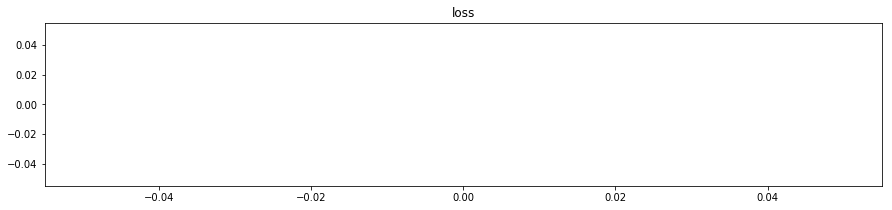

  6%|▌         | 999/17500 [00:04<01:07, 245.25it/s]

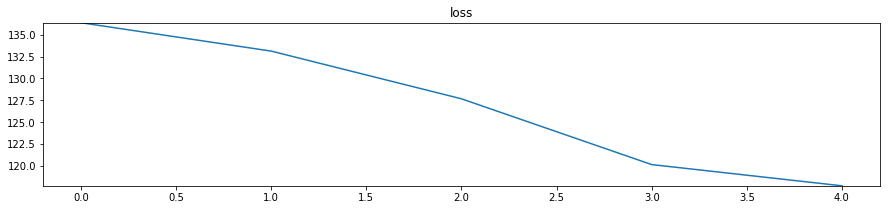

  9%|▊         | 1496/17500 [00:05<01:01, 259.59it/s]

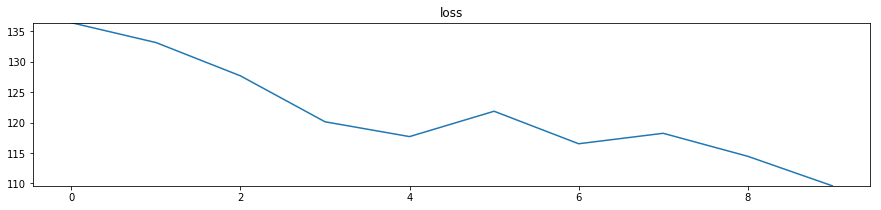

 11%|█▏        | 1997/17500 [00:07<00:56, 273.03it/s]

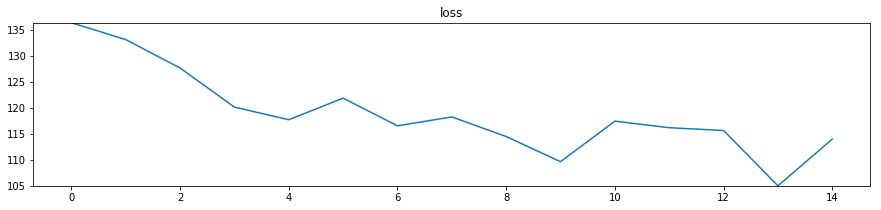

 14%|█▍        | 2497/17500 [00:08<00:53, 280.71it/s]

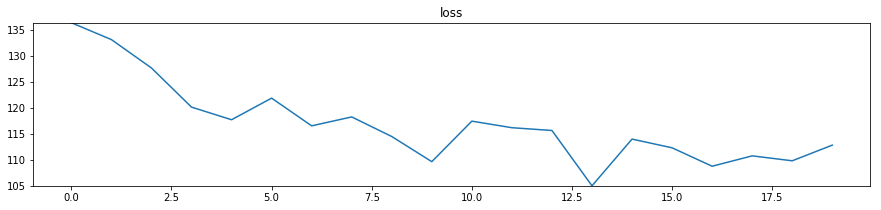

 17%|█▋        | 2990/17500 [00:10<00:52, 278.73it/s]

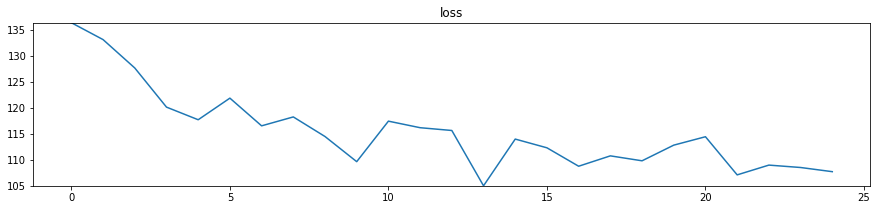

 20%|█▉        | 3483/17500 [00:12<00:50, 278.73it/s]

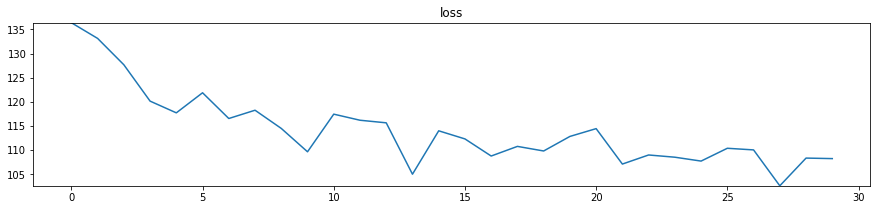

 23%|██▎       | 3988/17500 [00:14<00:47, 283.39it/s]

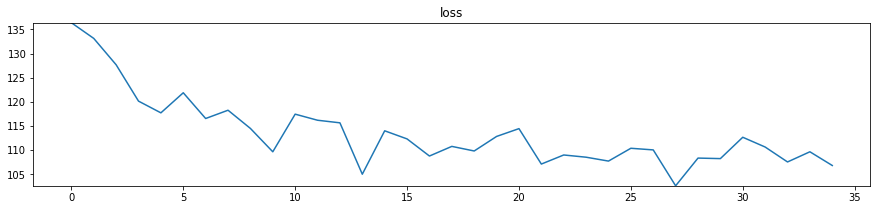

 26%|██▌       | 4481/17500 [00:15<00:45, 286.01it/s]

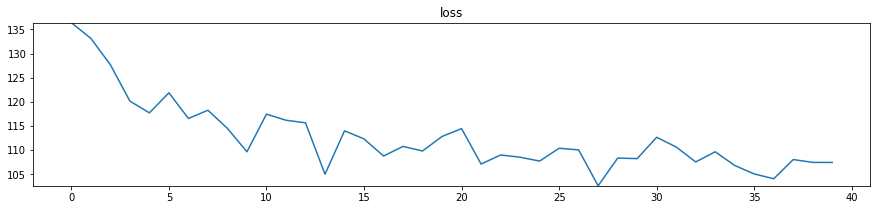

 29%|██▊       | 4990/17500 [00:17<00:43, 287.04it/s]

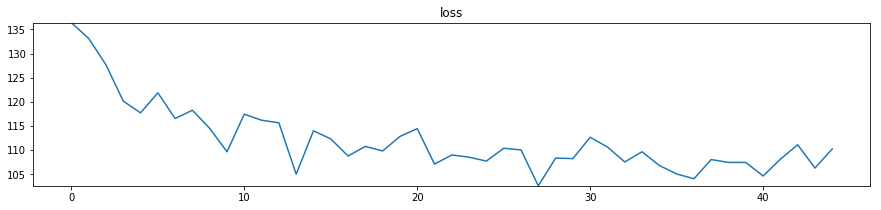

 31%|███▏      | 5488/17500 [00:18<00:41, 291.20it/s]

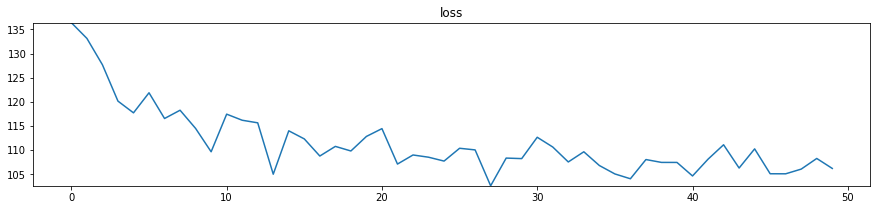

 34%|███▍      | 5993/17500 [00:20<00:39, 294.63it/s]

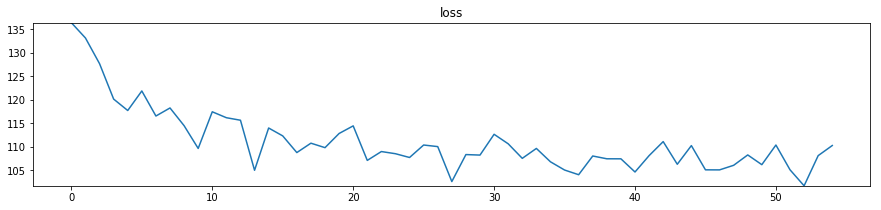

 37%|███▋      | 6483/17500 [00:22<00:37, 293.49it/s]

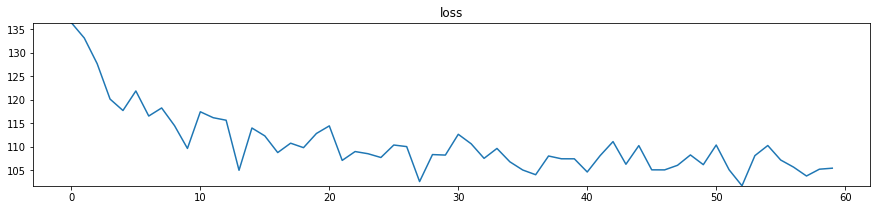

 40%|███▉      | 6997/17500 [00:23<00:35, 294.31it/s]

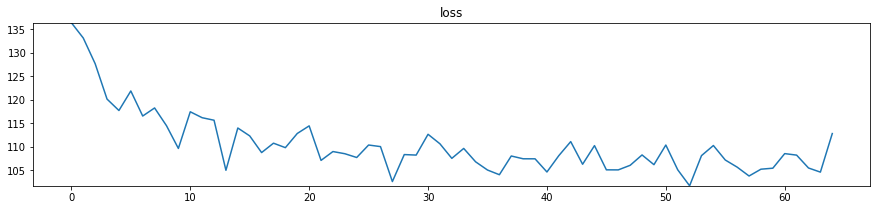

 43%|████▎     | 7488/17500 [00:25<00:33, 295.64it/s]

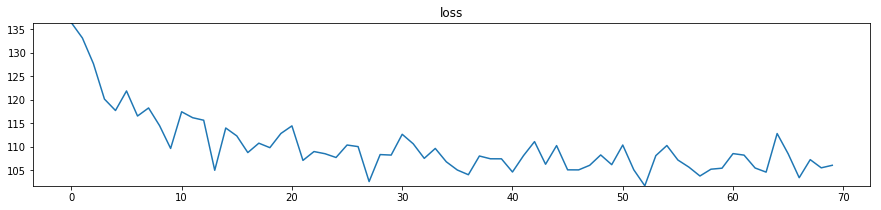

 46%|████▌     | 7974/17500 [00:27<00:32, 294.78it/s]

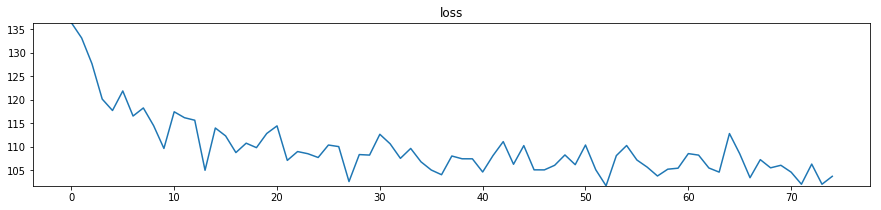

 48%|████▊     | 8476/17500 [00:28<00:30, 294.50it/s]

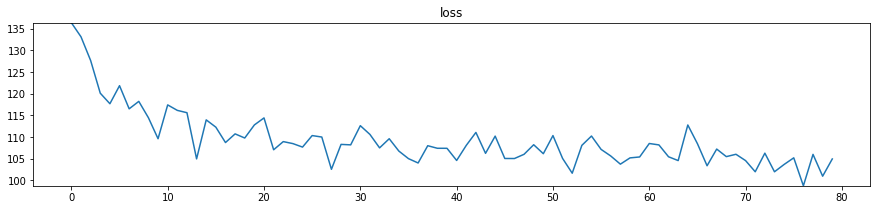

 51%|█████▏    | 8979/17500 [00:30<00:28, 295.44it/s]

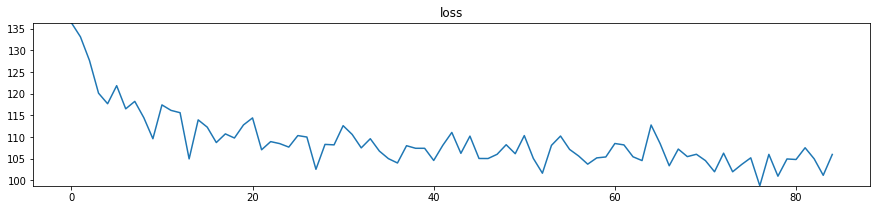

 54%|█████▍    | 9483/17500 [00:32<00:27, 296.31it/s]

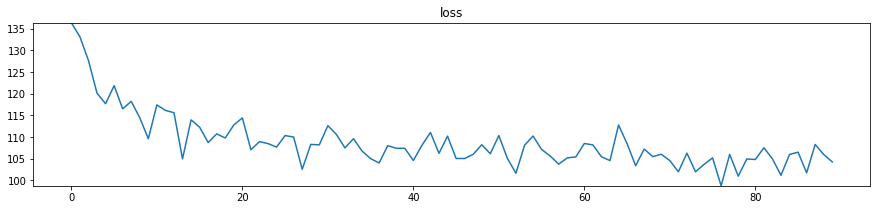

 57%|█████▋    | 9989/17500 [00:33<00:25, 297.03it/s]

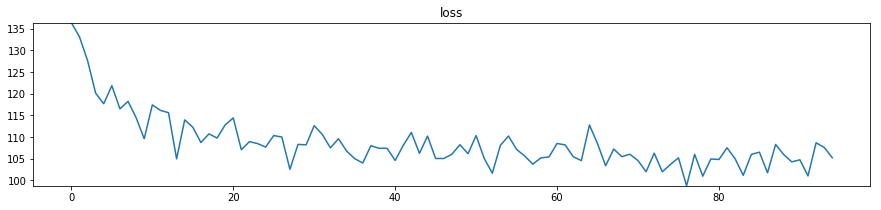

 60%|█████▉    | 10497/17500 [00:35<00:23, 298.10it/s]

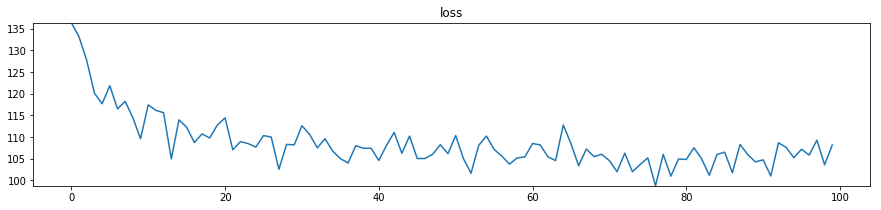

 63%|██████▎   | 10989/17500 [00:36<00:21, 297.23it/s]

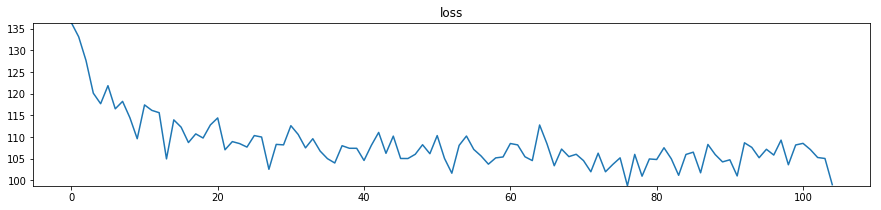

 66%|██████▌   | 11497/17500 [00:38<00:20, 298.26it/s]

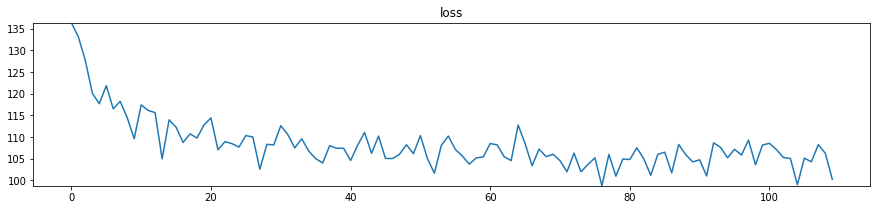

 68%|██████▊   | 11986/17500 [00:40<00:18, 297.55it/s]

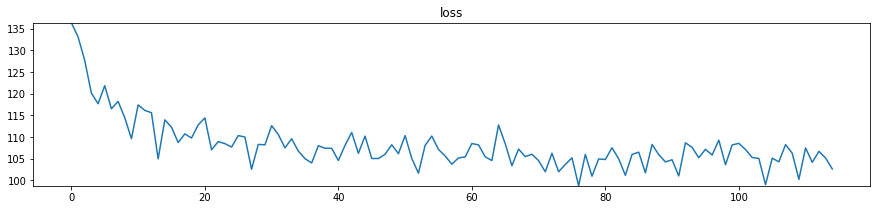

 71%|███████▏  | 12478/17500 [00:42<00:16, 296.64it/s]

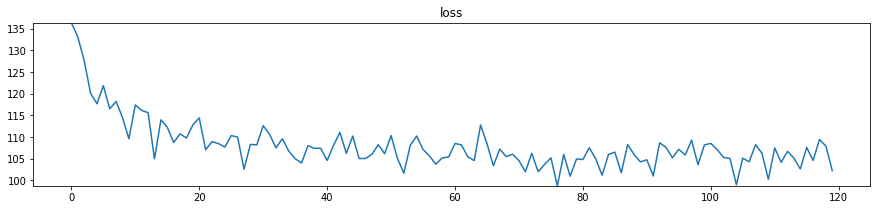

 74%|███████▍  | 12993/17500 [00:43<00:15, 297.02it/s]

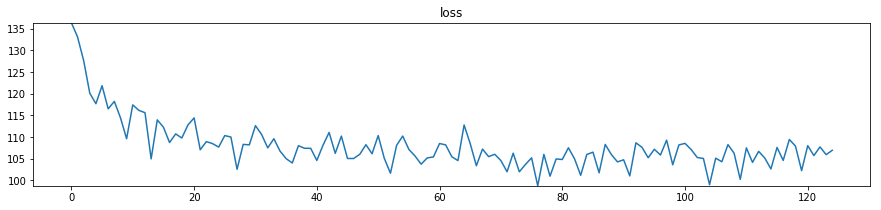

 77%|███████▋  | 13488/17500 [00:45<00:13, 297.03it/s]

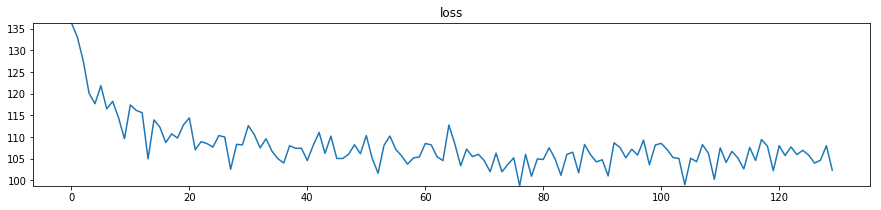

 80%|███████▉  | 13982/17500 [00:47<00:11, 297.28it/s]

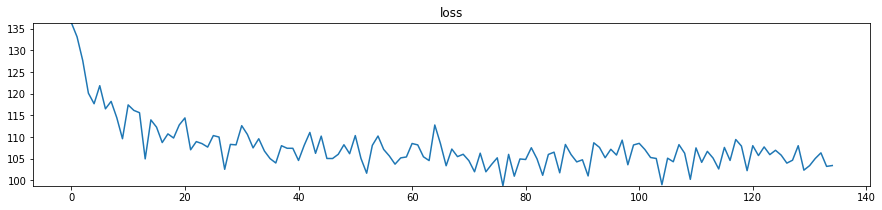

 83%|████████▎ | 14487/17500 [00:48<00:10, 297.10it/s]

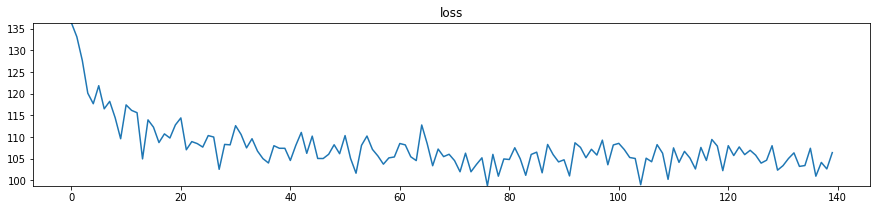

 86%|████████▌ | 14980/17500 [00:50<00:08, 297.51it/s]

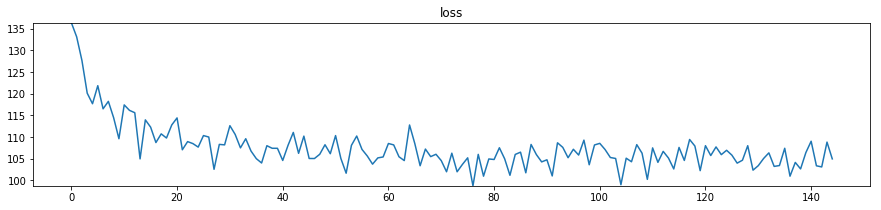

 89%|████████▊ | 15494/17500 [00:51<00:06, 298.17it/s]

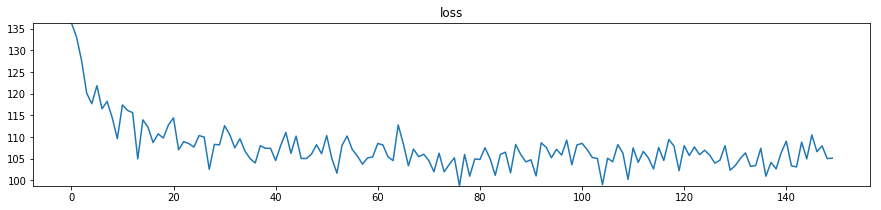

 91%|█████████▏| 15978/17500 [00:53<00:05, 298.26it/s]

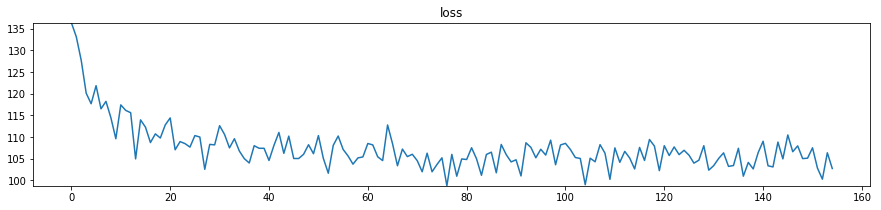

 94%|█████████▍| 16488/17500 [00:55<00:03, 298.15it/s]

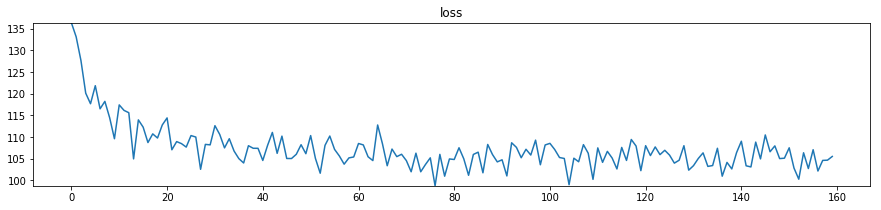

 97%|█████████▋| 16984/17500 [00:56<00:01, 298.05it/s]

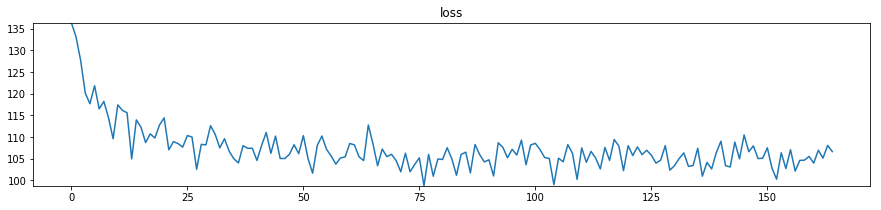

100%|█████████▉| 17482/17500 [00:58<00:00, 297.24it/s]

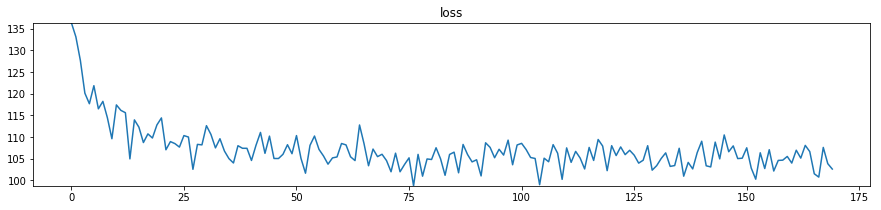

  3%|▎         | 466/17500 [00:01<00:48, 349.32it/s]

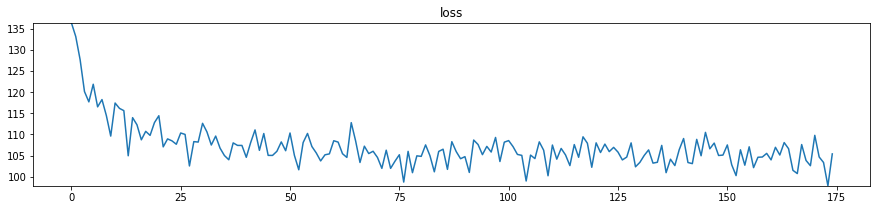

  6%|▌         | 985/17500 [00:02<00:50, 329.14it/s]

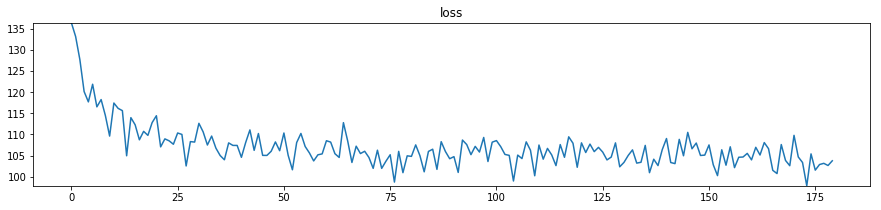

  8%|▊         | 1486/17500 [00:04<00:49, 321.92it/s]

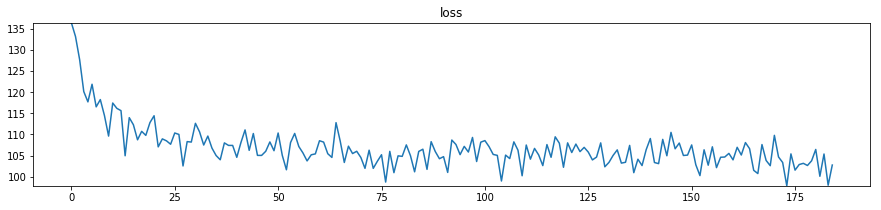

 11%|█▏        | 1997/17500 [00:06<00:48, 319.48it/s]

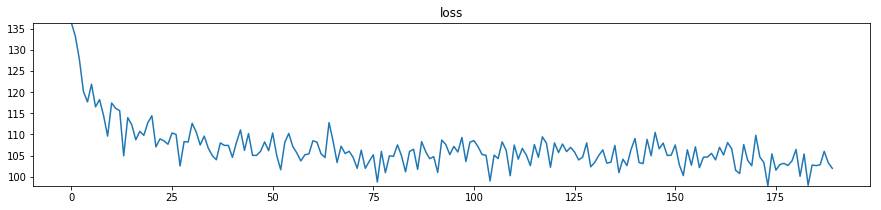

 14%|█▍        | 2499/17500 [00:07<00:47, 319.17it/s]

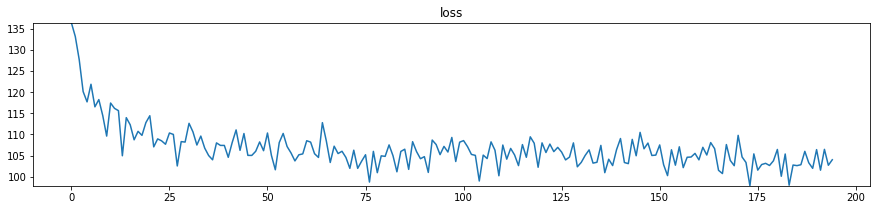

 17%|█▋        | 2969/17500 [00:09<00:45, 318.21it/s]

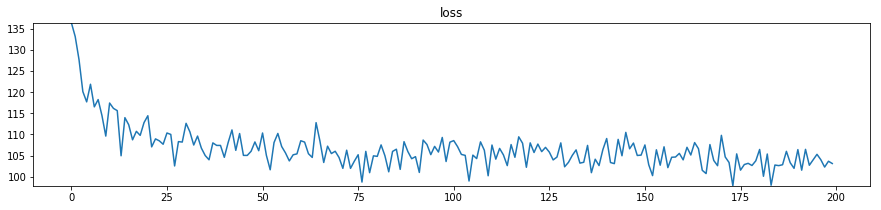

 20%|█▉        | 3497/17500 [00:11<00:44, 311.91it/s]

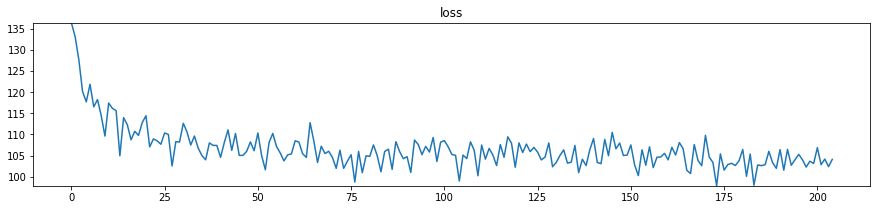

 23%|██▎       | 3990/17500 [00:13<00:44, 304.26it/s]

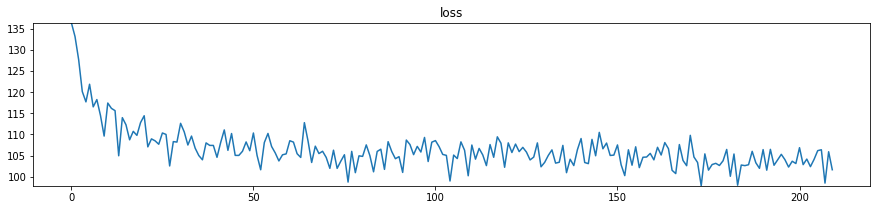

 26%|██▌       | 4496/17500 [00:14<00:43, 301.41it/s]

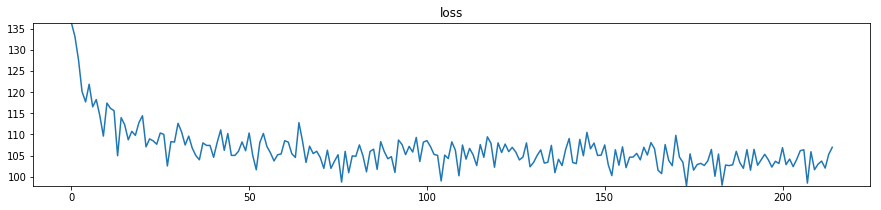

 29%|██▊       | 4992/17500 [00:16<00:41, 298.00it/s]

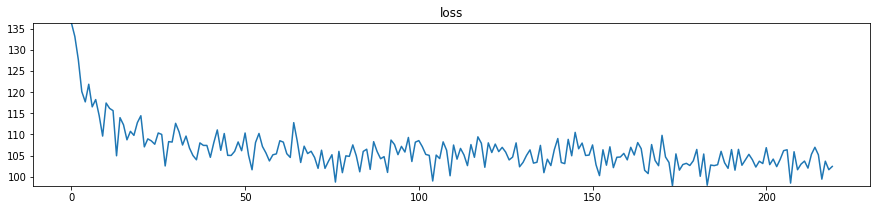

 31%|███▏      | 5479/17500 [00:18<00:40, 297.22it/s]

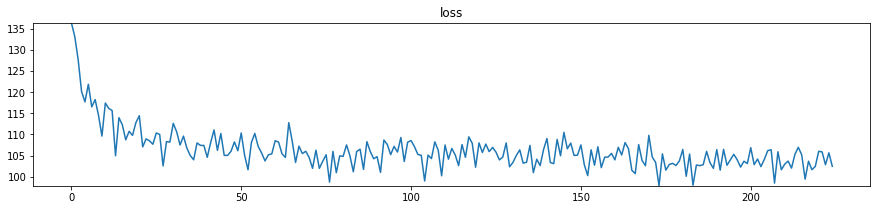

 34%|███▍      | 5983/17500 [00:20<00:39, 294.90it/s]

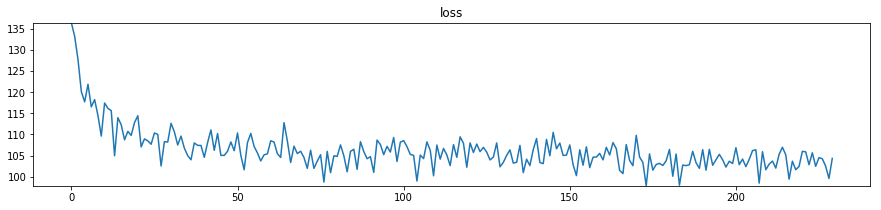

 37%|███▋      | 6484/17500 [00:21<00:37, 295.07it/s]

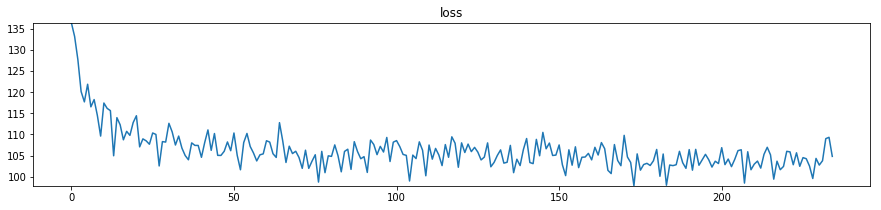

 40%|███▉      | 6965/17500 [00:23<00:35, 295.84it/s]

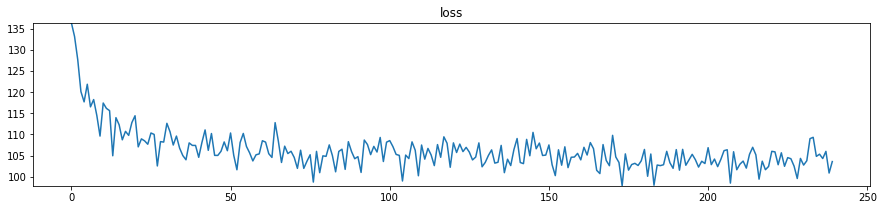

 43%|████▎     | 7473/17500 [00:25<00:34, 294.88it/s]

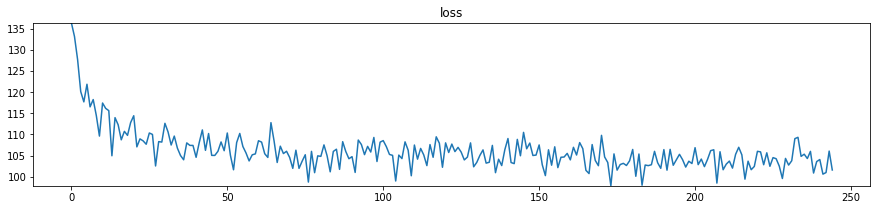

 46%|████▌     | 7974/17500 [00:27<00:32, 294.80it/s]

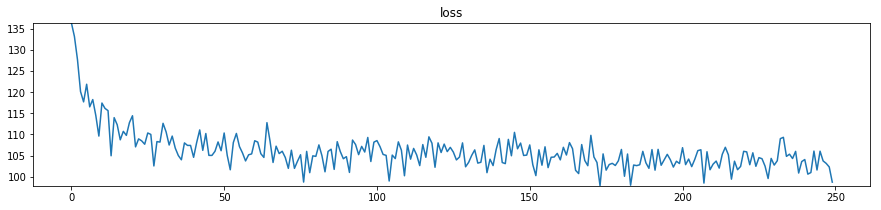

 48%|████▊     | 8478/17500 [00:28<00:30, 294.71it/s]

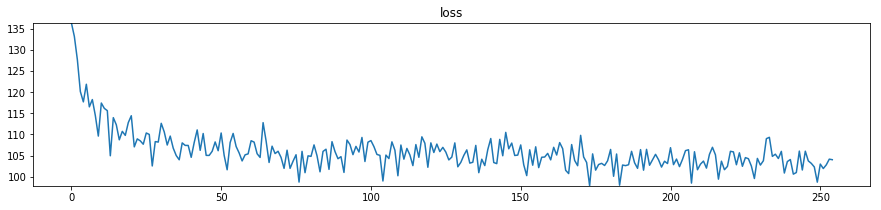

 51%|█████▏    | 8982/17500 [00:30<00:28, 294.71it/s]

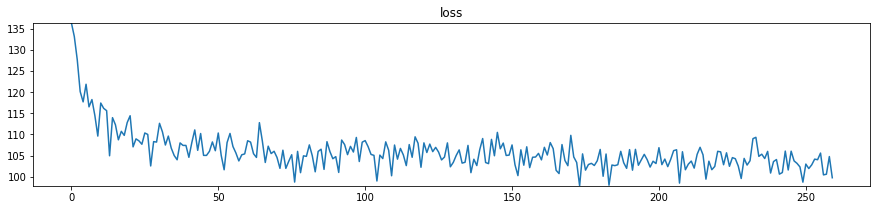

 54%|█████▍    | 9469/17500 [00:32<00:27, 294.28it/s]

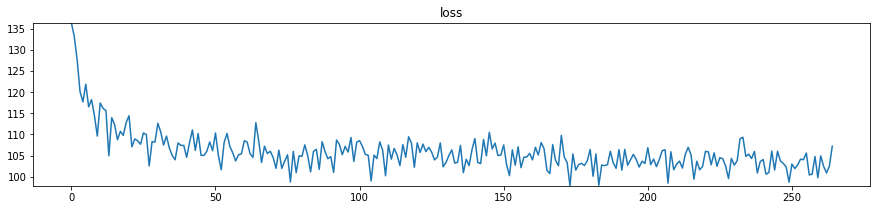

 57%|█████▋    | 9986/17500 [00:33<00:25, 294.48it/s]

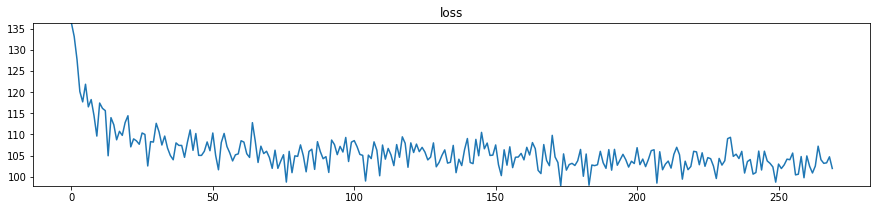

 60%|█████▉    | 10483/17500 [00:35<00:23, 293.21it/s]

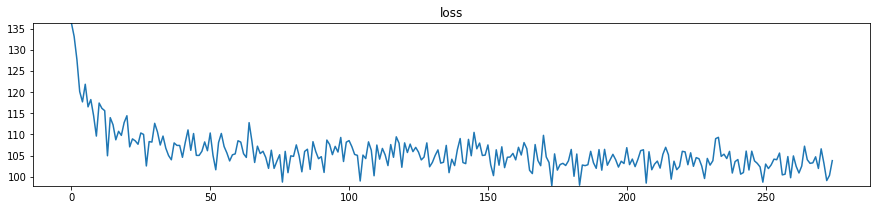

 63%|██████▎   | 10962/17500 [00:37<00:22, 294.45it/s]

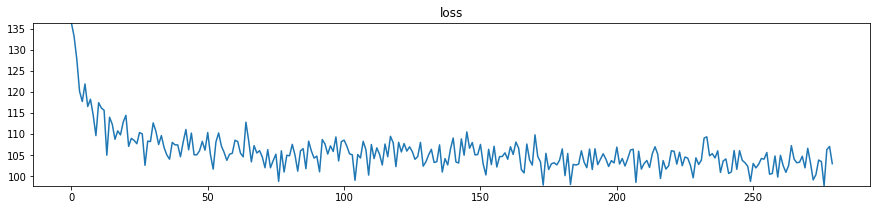

 66%|██████▌   | 11487/17500 [00:38<00:20, 295.52it/s]

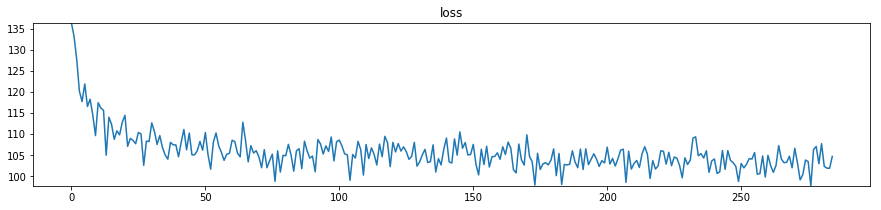

 69%|██████▊   | 11989/17500 [00:40<00:18, 295.45it/s]

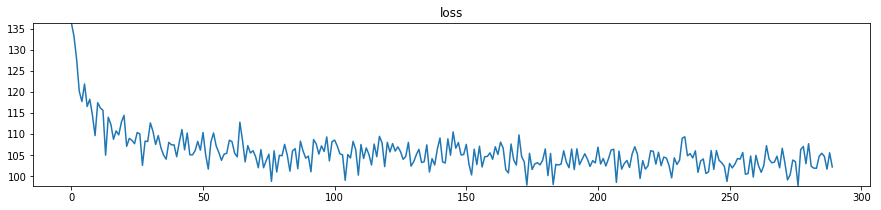

 71%|███████▏  | 12470/17500 [00:42<00:17, 295.45it/s]

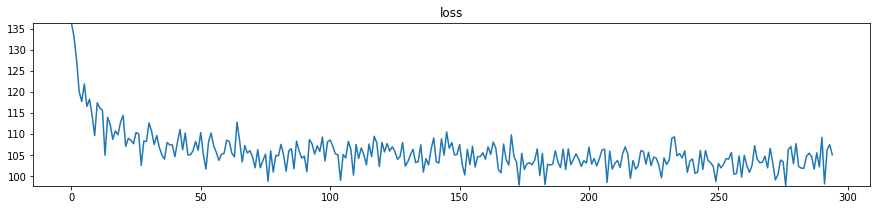

 74%|███████▍  | 12968/17500 [00:43<00:15, 295.96it/s]

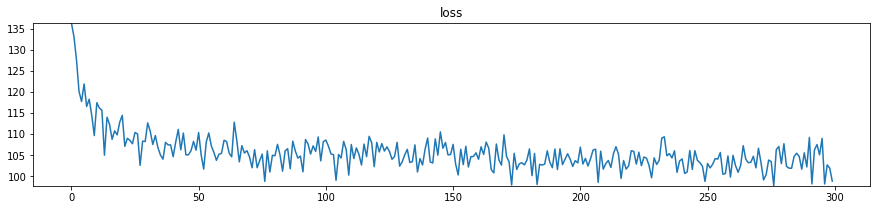

 77%|███████▋  | 13489/17500 [00:45<00:13, 296.29it/s]

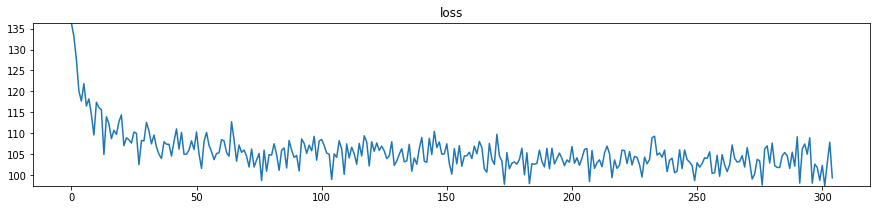

 80%|███████▉  | 13972/17500 [00:47<00:11, 297.15it/s]

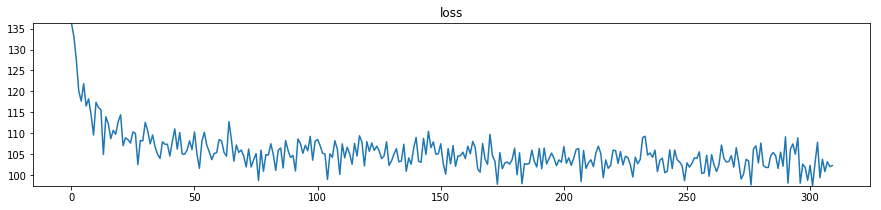

 83%|████████▎ | 14472/17500 [00:48<00:10, 297.19it/s]

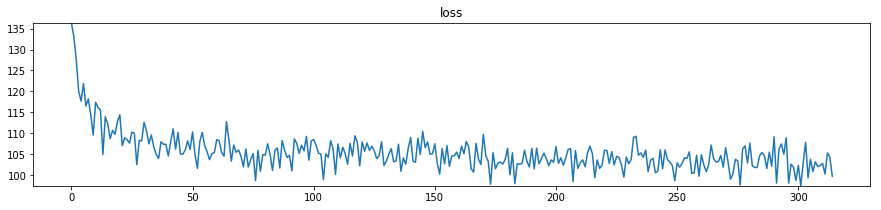

 86%|████████▌ | 14972/17500 [00:50<00:08, 296.63it/s]

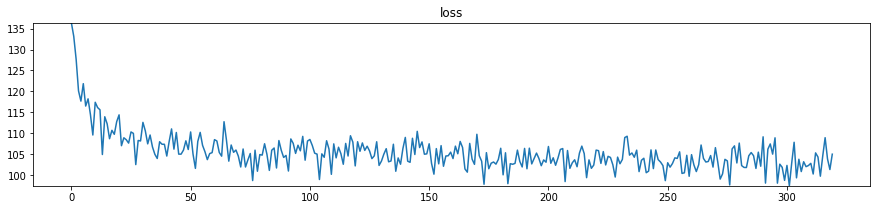

 89%|████████▊ | 15499/17500 [00:52<00:06, 296.32it/s]

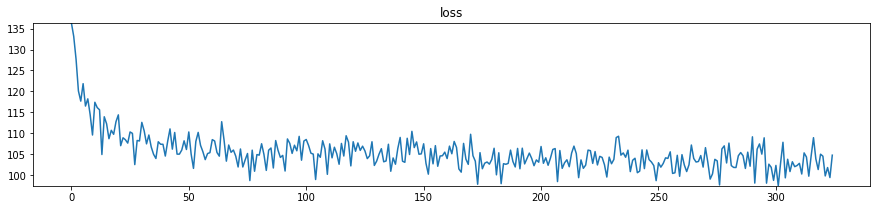

 91%|█████████▏| 15980/17500 [00:53<00:05, 296.50it/s]

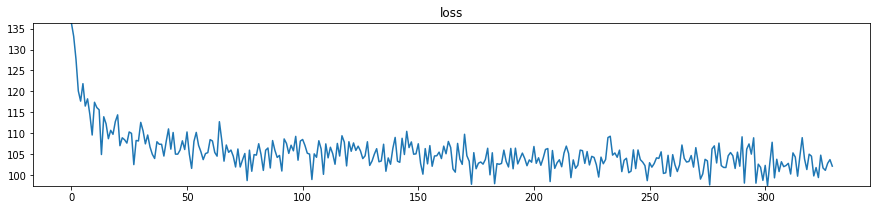

 94%|█████████▍| 16466/17500 [00:55<00:03, 297.17it/s]

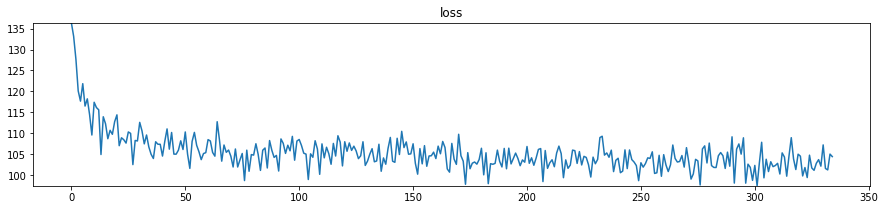

 97%|█████████▋| 16969/17500 [00:56<00:01, 297.88it/s]

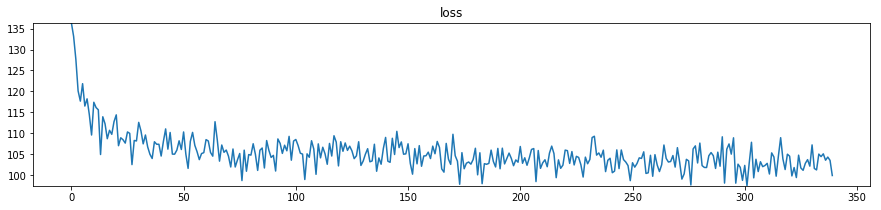

100%|█████████▉| 17482/17500 [00:58<00:00, 298.23it/s]

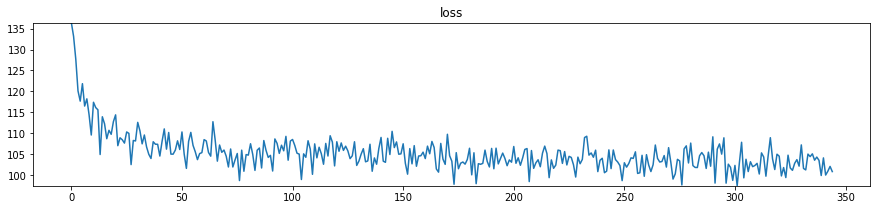

100%|██████████| 17500/17500 [00:58<00:00, 297.33it/s]


In [16]:
num_steps_per_epoch = xtr.shape[0] / batch_size
num_epochs = 35
num_steps = int(num_steps_per_epoch * num_epochs)

utils.trainer(sess, num_steps, train_op, create_feed_dict_fn(0.001), [metrics], [plot_metrics])

num_epochs = 35
num_steps = int(num_steps_per_epoch * num_epochs)
utils.trainer(sess, num_steps, train_op, create_feed_dict_fn(0.0001), [metrics], [plot_metrics])

## Compute training and validation loss

In [17]:
def total_loss(data_tensor, num_steps):
    loss_np = 0
    for i in range(num_steps):
        loss_np += sess.run(loss, feed_dict={x_ph: data_tensor.eval()})
    return loss_np/num_steps

print("Train loss: ", total_loss(x_train, 100))
print("Test loss: ", total_loss(x_test, 100))

Train loss:  104.1758780670166
Test loss:  107.09360885620117


## Plot example reconstructions

Training set

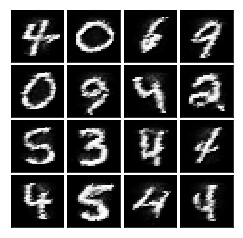

In [18]:
x_recon_np = sess.run(tf.nn.sigmoid(x_hat), feed_dict={x_ph: x_train.eval()})
utils.plot_4x4_grid(x_recon_np)

Validation set

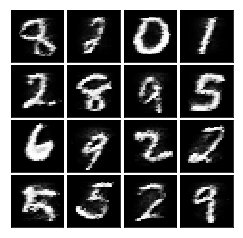

In [19]:
x_recon_np = sess.run(tf.nn.sigmoid(x_hat), feed_dict={x_ph: x_test.eval()})
utils.plot_4x4_grid(x_recon_np)

## Sampling from trained model


Taken from: http://bjlkeng.github.io/posts/autoregressive-autoencoders/

One final idea that isn't explicitly mentioned in the paper is how to generate new samples. Remember, we now have a fully generative probabilistic model for our autoencoder. It turns out it's quite easy but a bit slow. The main idea (for binary data):

1. Randomly generate vector $x$, set $i=1$.
2. Feed xx into autoencoder and generate outputs $\hat x$ for the network, set $p = \hat x_i$.
3. Sample from a Bernoulli distribution with parameter $p$, set input $x_i=\mathrm{Bernoulli}(p)$.
4. Increment i and repeat steps 2-4 until i > D.

Basically, we're iteratively calculating $p(x_i|x_{<i})$ by doing a forward pass on the autoencoder each time. Along the way, we sample from the Bernoulli distribution and feed the sampled value back into the autoencoder to compute the next parameter for the next bit. It's a bit inefficient but MADE is also a relatively small modification to the vanilla autoencoder so you can't ask for too much.



In [20]:
p_x = tf.nn.sigmoid(x_hat)

In [21]:
x_generated = np.zeros([batch_size, 784])
for i in tqdm(range(784)):
    x_generated_new = sess.run(p_x, feed_dict={x_ph: x_generated})
    p_i = x_generated_new[:, i]
    epsilon = np.random.rand(batch_size)
    v = 1*(p_i >= epsilon)
    x_generated[:, i] = v

100%|██████████| 784/784 [00:02<00:00, 320.93it/s]


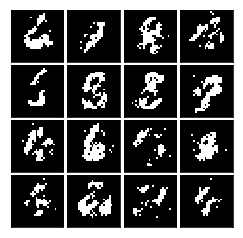

In [22]:
utils.plot_4x4_grid(x_generated)

This can be improved by taking more layers